Training samples: (97493, 10)


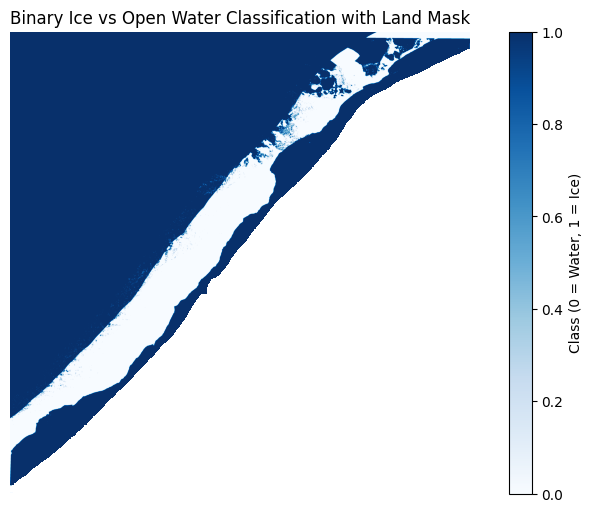

Binary ice/water classification saved to: /Volumes/toshiba/Wainwright/Sentinel2/drive-download-20250203T061203Z-002/Sentinel2_Wainwright_AK_20240306_6_binary_ice_water_classified.tif


In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterio.features import geometry_mask, rasterize
from shapely.geometry import box
from sklearn.ensemble import RandomForestClassifier
from scipy import ndimage
from skimage.filters import sobel
from scipy.ndimage import distance_transform_edt
from skimage.measure import label, regionprops

# --- Paths ---
tif_path = "/Volumes/toshiba/Wainwright/Sentinel2/drive-download-20250203T061203Z-002/Sentinel2_Wainwright_AK_20240326_24.tif"
vector_path = "/Volumes/toshiba/Wainwright/Sentinel2/class.geojson"
coastline_path = r"/Users/anastringer_1/Desktop/418-alaska-coastline-1-250-000/Physical Features - Coast - Alaska Coast - 250,000_LINE.shp"

# --- Load the RGB Image ---
with rasterio.open(tif_path) as src:
    blue = src.read(1).astype('float32')
    green = src.read(2).astype('float32')
    red = src.read(3).astype('float32')
    profile = src.profile
    transform = src.transform
    raster_crs = src.crs
    height, width = src.height, src.width

# --- Normalize Bands ---
eps = 1e-6
blue_norm = blue / (np.max(blue) + eps)
green_norm = green / (np.max(green) + eps)
red_norm = red / (np.max(red) + eps)

# --- Create Spectral Features ---
b2_b3 = blue_norm / (green_norm + eps)
b3_b4 = green_norm / (red_norm + eps)
b2_b4 = blue_norm / (red_norm + eps)
brightness = np.sqrt(blue_norm**2 + green_norm**2 + red_norm**2)

# --- Add Texture Features ---
std_texture = ndimage.generic_filter(brightness, np.std, size=3)
sobel_edges = sobel(brightness)

# --- Distance to Coast ---
coast = gpd.read_file(coastline_path)
coast = coast.to_crs(raster_crs)

# Clip to raster bounds
bbox = box(*rasterio.transform.array_bounds(height, width, transform))
coast_clipped = coast.clip(bbox)

# Rasterize coastline as a binary mask
coast_mask = rasterize(
    [(geom, 1) for geom in coast_clipped.geometry],
    out_shape=(height, width),
    transform=transform,
    fill=0,
    all_touched=True,
    dtype='uint8'
)

# Create a land mask: everything to the right (east) of the coastline is land
land_mask = np.zeros_like(coast_mask, dtype=bool)
for row in range(height):
    encountered_coast = False
    for col in range(width):
        if coast_mask[row, col] == 1:
            encountered_coast = True
        if encountered_coast:
            land_mask[row, col] = True

# --- Compute distance to coast ---
inv_coast = coast_mask == 0
dist_to_coast = distance_transform_edt(inv_coast) * transform[0]  # distance in meters

# --- Stack Features ---
features = np.stack([
    blue_norm,
    green_norm,
    red_norm,
    b2_b3,
    b3_b4,
    b2_b4,
    brightness,
    std_texture,
    sobel_edges,
    dist_to_coast
], axis=0)

n_bands = features.shape[0]
X_all = features.reshape(n_bands, -1).T

# --- Load and Reproject Training Polygons ---
gdf = gpd.read_file(vector_path)
gdf = gdf.to_crs(raster_crs)

# --- Extract Training Data ---
train_pixels = []
train_labels = []

for _, row in gdf.iterrows():
    geom = [row.geometry]
    mask = geometry_mask(
        geom,
        transform=transform,
        invert=True,
        out_shape=(height, width)
    )

    for band in range(n_bands):
        band_data = features[band]
        band_values = band_data[mask]
        if band == 0:
            pixel_stack = band_values[:, None]
        else:
            pixel_stack = np.hstack((pixel_stack, band_values[:, None]))

    train_pixels.append(pixel_stack)
    train_labels.append(np.full(pixel_stack.shape[0], row['id']))

X_train = np.vstack(train_pixels)
y_train = np.concatenate(train_labels)
print("Training samples:", X_train.shape)

# --- Collapse to Binary Ice/Water Labels ---
y_train_binary = np.where(y_train == 0, 0, 1)  # 0 = open water, 1 = ice (all other classes)

# --- Train Binary Classifier ---
binary_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
binary_clf.fit(X_train, y_train_binary)

# --- Predict Entire Image ---
y_pred_binary = binary_clf.predict(X_all)
classified_binary = y_pred_binary.reshape(height, width).astype('float32')

# --- Mask Land Area ---
classified_binary = np.where(land_mask, np.nan, classified_binary)

# --- Plot Result ---
plt.figure(figsize=(10, 6))
plt.imshow(classified_binary, cmap='Blues')
plt.title("Binary Ice vs Open Water Classification with Land Mask")
plt.axis('off')
cbar = plt.colorbar(label='Class (0 = Water, 1 = Ice)')
plt.show()

# --- Save classified image as GeoTIFF ---
output_path = tif_path.replace(".tif", "_binary_ice_water_classified.tif")
profile.update(dtype='float32', count=1, nodata=np.nan)

with rasterio.open(output_path, 'w', **profile) as dst:
    dst.write(classified_binary, 1)

print(f"Binary ice/water classification saved to: {output_path}")


Plot the detected Ice Edge 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm

# --- Paths ---
tif_path = "/Volumes/toshiba/Wainwright/Sentinel2/drive-download-20250203T061203Z-002/Sentinel2_Wainwright_AK_20240326_24_binary_ice_water_classified.tif"
edge_csv_path = "/Users/anastringer_1/Desktop/Sea_Ice_Extent/wainwright0324.csv"

# --- Load Raster ---
with rasterio.open(tif_path) as src:
    classified = src.read(1)
    transform = src.transform
    extent = [
        transform * (0, 0),  # top-left corner (x, y)
        transform * (src.width, 0),  # top-right
        transform * (src.width, src.height),  # bottom-right
        transform * (0, src.height)  # bottom-left
    ]
    xmin = extent[0][0]
    xmax = extent[2][0]
    ymin = extent[2][1]
    ymax = extent[0][1]

# --- Load Ice Edge CSV ---
df = pd.read_csv(edge_csv_path)

# --- Prepare Classified Image for Display ---
# Replace NaN (coast/land) with a custom value -1
display_array = np.copy(classified)
display_array[np.isnan(display_array)] = -1

# --- Define Custom Colormap ---
# -1 = coast (black), 0 = water (blue), 1 = ice (white)
cmap = ListedColormap(['black', '#0077be', 'white'])  # order matters: -1, 0, 1
bounds = [-1.5, -0.5, 0.5, 1.5]
norm = BoundaryNorm(bounds, cmap.N)

# --- Plot ---
plt.figure(figsize=(10, 6))
plt.imshow(display_array, cmap=cmap, norm=norm, extent=(xmin, xmax, ymin, ymax))
plt.title("Ice/Water Classification with Coast Mask & Ice Edge")
plt.plot(df['X_Coord'], df['Y_Coord'], color='red', linewidth=2, label='Detected Ice Edge')
plt.legend()
plt.axis('off')
plt.show()
